# King County Housing Prediction Analysis

In [1]:
# import packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

#set display parameters
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 500)


In [52]:
# import datafiles
training = pd.read_csv("datasets/kc_house_data_train.csv", index_col = 0)
imputed = pd.read_csv("datasets/bedroomsfilled.csv", index_col = 0)
extra = pd.read_csv("datasets/zip_code_extra_data_fixed.csv", index_col = 0)
date = pd.read_csv("datasets/date.csv", index_col = 0)

### Checking out the Sales dataframe

In [53]:
print(training.shape) #training and testing df to create a model for prediction
print(imputed.shape) #missing data for 12 rows (no bedrooms)
print(extra.shape) # extra data on the 70 zipcodes from https://www.unitedstateszipcodes.org/
print(date.shape) # date from the training datafile. 
sales = training.copy()
prices=pd.DataFrame(sales["price"])
sales.head()

(17290, 21)
(12, 21)
(70, 54)
(17290, 1)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [54]:
sales.tail()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
17285,627300195,20150303T000000,750000.0,5,2.50,3240,9960,1.0,0,1,3,8,2020,1220,1958,0,98008,47.5858,-122.112,2730,10400
17286,8819900270,20140520T000000,440000.0,2,1.75,1300,4000,2.0,0,0,3,7,1300,0,1948,0,98105,47.6687,-122.288,1350,4013
17287,3816300095,20140514T000000,310000.0,3,1.00,1050,9876,1.0,0,0,3,7,1050,0,1953,0,98028,47.7635,-122.262,1760,9403
17288,122069107,20141204T000000,427500.0,3,1.50,1900,43186,1.5,0,0,4,7,1300,600,1971,0,98038,47.4199,-121.990,2080,108028
17289,6703100135,20150116T000000,348000.0,3,1.50,1330,6768,1.0,0,0,4,7,1330,0,1952,0,98155,47.7366,-122.319,1320,6910


In [55]:
sales.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [6]:
sales.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.729000e+04,1.729000e+04,17290.000000,17290.000000,17290.000000,1.729000e+04,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000,17290.000000
mean,4.565502e+09,5.407395e+05,3.372470,2.111943,2081.464604,1.524340e+04,1.490312,0.007981,0.238519,3.408502,7.654425,1789.306015,292.158589,1970.792019,83.806304,98078.193175,47.560058,-122.214258,1987.986698,12873.475824
std,2.874656e+09,3.733190e+05,0.939346,0.770476,920.018539,4.230462e+04,0.538909,0.088985,0.775229,0.651296,1.174718,829.265107,443.151874,29.343516,400.329376,53.607949,0.138412,0.140857,684.802635,27227.437583
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,659.000000
25%,2.114701e+09,3.210000e+05,3.000000,1.500000,1430.000000,5.081250e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1200.000000,0.000000,1951.000000,0.000000,98033.000000,47.471200,-122.329000,1490.000000,5111.250000
50%,3.903650e+09,4.500000e+05,3.000000,2.250000,1920.000000,7.642000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1974.000000,0.000000,98065.000000,47.571600,-122.230000,1840.000000,7622.500000
75%,7.301150e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.072575e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2214.500000,560.000000,1996.000000,0.000000,98118.000000,47.677900,-122.126000,2360.000000,10101.750000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,858132.000000


In [7]:
corr = sales.corr()  # checking correlation

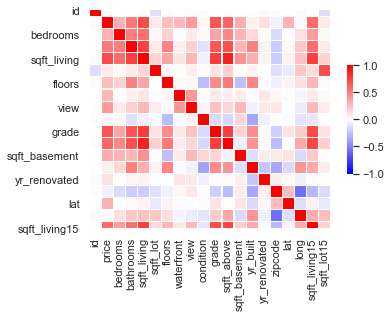

In [8]:
sns.heatmap(corr, cmap="bwr", vmax=1, vmin=-1, center=0, square = True,
             linewidths=.1, cbar_kws={"shrink": .5})

In [11]:

sales.drop(columns=["id","date"], inplace = True) #Dropping "id" since it does not affect the price. "Date" is also being removed. 


In [12]:
sales.shape

(17290, 19)

In [61]:
# import datafiles
training = pd.read_csv("datasets/kc_house_data_train.csv", index_col = 0)
imputed = pd.read_csv("datasets/bedroomsfilled.csv", index_col = 0)
extra = pd.read_csv("datasets/zip_code_extra_data_fixed.csv", index_col = 0)
date = pd.read_csv("datasets/date.csv", index_col = 0)

### Checking out the Sales dataframe



print(training.shape) #training and testing df to create a model for prediction
print(imputed.shape) #missing data for 12 rows (no bedrooms)
print(extra.shape) # extra data on the 70 zipcodes from https://www.unitedstateszipcodes.org/
print(date.shape) # date from the training datafile. 
sales = training.copy()
sales.drop(columns=["id","date"], inplace = True)
prices=pd.DataFrame(sales["price"])
sales.head()
print(sales.shape)




(17290, 21)
(12, 21)
(70, 54)
(17290, 1)
(17290, 19)


### Conducting a train-test split to see how the current model holds up (Naive model) 

In [62]:
X = sales.drop(columns = "price")
y = sales.price

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=42)

from sklearn.linear_model import LinearRegression
from sklearn import metrics

multi_lr_model = LinearRegression() # model

multi_lr_model.fit(X_train, y_train) # fit

y_pred = multi_lr_model.predict(X_test) # prediction


r_square = metrics.r2_score(y_test, y_pred)
original_mse = metrics.mean_squared_error(y_test, y_pred)


print("R Square               : ", r_square)
print("Original Root Mean Squared Error: ", original_mse**(1/2))

R Square               :  0.7027786929887444
Original Root Mean Squared Error:  198865.02952198777


# Naive model: R_square of 0.702778 and RMSE of 198865.0295

In [63]:
def multicolinear_features(data):
    df=data.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    df['pairs'] = list(zip(df.level_0, df.level_1))
    df.set_index(['pairs'], inplace = True)
    df.drop(columns=['level_1', 'level_0'], inplace = True)
    df.columns = ['cc'] #correlation column
    df.drop_duplicates(inplace=True)
    return df[(df.cc>.9) & (df.cc<1) ]

multicolinear_features(sales) #checking for multicolinearity

,cc
pairs,


In [64]:
sales[sales["bedrooms"]== 0]


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
483,355000.0,0,0.00,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050
1120,1095000.0,0,0.00,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
2430,265000.0,0,0.75,384,213444,1.0,0,0,3,4,384,0,2003,0,98070,47.4177,-122.491,1920,224341
3032,235000.0,0,0.00,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
3609,339950.0,0,2.50,2290,8319,2.0,0,0,3,8,2290,0,1985,0,98042,47.3473,-122.151,2500,8751
5424,380000.0,0,0.00,1470,979,3.0,0,2,3,8,1470,0,2006,0,98133,47.7145,-122.356,1470,1399
6409,288000.0,0,1.50,1430,1650,3.0,0,0,3,7,1430,0,1999,0,98125,47.7222,-122.290,1430,1650
9286,1295650.0,0,0.00,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061
10067,142000.0,0,0.00,290,20875,1.0,0,0,1,1,290,0,1963,0,98024,47.5308,-121.888,1620,22850
10074,240000.0,0,2.50,1810,5669,2.0,0,0,3,7,1810,0,2003,0,98038,47.3493,-122.053,1810,5685


In [65]:
sales["bedrooms"].max()

33

In [66]:
print(sales.shape, imputed.shape)

(17290, 19) (12, 21)


In [67]:
sales.isnull().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [68]:
imputed #dataframe with information on the missing bedrooms

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
483,3374500520,20150429T000000,355000.0,4,2.50,2460,8049,2.0,0,0,3,8,2460,0,1990,0,98031,47.4095,-122.168,2520,8050
1120,6306400140,20140612T000000,1095000.0,5,3.00,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000
2430,1222029077,20141029T000000,265000.0,1,0.75,384,213444,1.0,0,0,3,4,384,0,2003,0,98070,47.4177,-122.491,1920,224341
3032,7849202190,20141223T000000,235000.0,3,2.00,1470,4800,2.0,0,0,3,7,1470,0,1996,0,98065,47.5265,-121.828,1060,7200
3609,2569500210,20141117T000000,339950.0,4,3.00,2290,8319,2.0,0,0,3,8,2290,0,1985,0,98042,47.3473,-122.151,2500,8751
5424,3918400017,20150205T000000,380000.0,3,2.50,1470,979,3.0,0,2,3,8,1470,0,2006,0,98133,47.7145,-122.356,1470,1399
6409,1453602309,20140805T000000,288000.0,2,1.50,1430,1650,3.0,0,0,3,7,1430,0,1999,0,98125,47.7222,-122.290,1430,1650
9286,2954400190,20140624T000000,1295650.0,4,4.50,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061
10067,3980300371,20140926T000000,142000.0,1,0.75,290,20875,1.0,0,0,1,1,290,0,1954,0,98024,47.5308,-121.888,1620,22850
10074,2310060040,20140925T000000,240000.0,4,2.50,1810,5669,2.0,0,0,3,7,1810,0,2003,0,98038,47.3493,-122.053,1810,5685


In [69]:
print(sales.shape, imputed.shape)

(17290, 19) (12, 21)


In [70]:
imputed.drop(columns=["id","date"], inplace = True)           # dropping 2 columns to match sales and id does not really affect the model.
imputed.shape

(12, 19)

In [71]:
imputed.isnull().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [72]:
print(sales.shape, imputed.shape) # checking to make sure both dataframes have the same amount of columns for the merge

(17290, 19) (12, 19)


# Merging Bedroom data for 12 rows and removing bedroom outliers

In [73]:
def filled_data(df,df2):
    index=df.loc[df.bedrooms == 0].index.to_list()
    df.drop(df.index[[index]], inplace=True)
    frames= [df, df2]
    train = pd.concat(frames)
    return train
sales=filled_data(sales, imputed)

In [74]:
print(sales.shape)


(17290, 19)


In [75]:
sales["bedrooms"].sort_values(ascending = False)

8597     33
2356     11
3680     10
11181    10
17114    10
         ..
15342     1
7846      1
14292     1
4298      1
9268      1
Name: bedrooms, Length: 17290, dtype: int64

In [76]:
# removes outliers - bedrooms  > 10

def cap_max(x, n, data, column):
    """
    x = the column number
    n = min number
    data = dataframe
    column = interested column from dataframe
    should be applied in a lambda function.
    For example: sales["bedrooms"].apply(lambda x: cutoff(x,10,sales,"bedrooms"))
    """
    if x > n:
        return data[column].median()
    else:
        return x
sales["bedrooms"]= sales["bedrooms"].apply(lambda x: cap_max(x,10,sales,"bedrooms"))   

In [77]:
sales["bedrooms"].sort_values(ascending = False)

3680     10.0
11181    10.0
17114    10.0
14156     9.0
3425      9.0
         ... 
4411      1.0
7474      1.0
11716     1.0
7482      1.0
3186      1.0
Name: bedrooms, Length: 17290, dtype: float64

In [78]:
sales["bathrooms"].sort_values(ascending = True)

9060     0.00
12982    0.00
7093     0.50
4622     0.50
12674    0.50
         ... 
15816    6.75
3425     7.50
7519     7.75
3275     8.00
10366    8.00
Name: bathrooms, Length: 17290, dtype: float64

In [79]:
def cap_min(x, n, data, column):
    """
    x = the column number
    n = min number
    data = dataframe
    column = interested column from dataframe
    should be applied in a lambda function.
    For example: sales["bedrooms"].apply(lambda x: cutoff(x,10,sales,"bedrooms"))
    """
    if x == n:
        return data[column].median()
    else:
        return x

In [81]:
sales["bathrooms"]= sales["bathrooms"].apply(lambda x: cap_min(x,0,sales,"bathroom"))  


In [82]:
sales.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,365000.0,4.0,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,865000.0,5.0,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,1038000.0,4.0,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,1490000.0,3.0,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,711000.0,3.0,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


In [83]:
sales.isnull().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

# Checking the effect of the new data additions

In [96]:
X = sales.drop(columns = ["price"])
y = sales.price

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=42)

In [97]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

multi_lr_model = LinearRegression() # model

multi_lr_model.fit(X_train, y_train) # fit

y_pred = multi_lr_model.predict(X_test) # prediction

model_score = multi_lr_model.score(X_test,y_test)
r_square = metrics.r2_score(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.median_absolute_error(y_test, y_pred)
ev = metrics.explained_variance_score(y_test, y_pred)

print(model_score)
print(mse)
print("Mae: ",  mae)
print("R Square               : ", r_square)
print("Root Mean Squared Error: ", mse**(1/2))

0.6906955354973479
43818591445.58683
Mae:  91521.51749724802
R Square               :  0.6906955354973479
Root Mean Squared Error:  209328.90733385782


# Adding More Data

In [98]:
print(sales.shape, extra.shape)

(17290, 19) (70, 54)


In [99]:
training_data = pd.merge(sales, extra, how='right', on='zipcode')


In [100]:
training_data.shape

(17290, 73)

In [101]:
training_data.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'full_time_earnings',
       'part_time_earnings', 'no_earnings', 'car_truck_van',
       'public_transportation', 'taxi', 'motorcycle', 'bike_walk_other',
       'work_home', 'less_than_hs', 'high_school_grad', 'associates',
       'bachelors', 'masters', 'professional_school_degree', 'doctorate',
       'public_school_enrollment', 'private_school_enrollment',
       'no_school_enrollment', 'for_rent', 'rented_and_unoccupied',
       'for_sale_only', 'sold_and_unoccupied', 'seasonal_or_rec_use',
       'migrant_worker_housing', 'vacant_other_reasons',
       'in_occupied_housing_units', 'adult_correctional_facility',
       'juvenile_facilities', 'nursing_facilities', 'other_institutional',
       'military_quarters', 'other_nonin

In [102]:
training_data = pd.merge(training_data, date, how = "left", left_index=True, right_index=True)
training_data["month"] = pd.DatetimeIndex(training_data["date"]).month

training_data.drop(columns=["date"], inplace = True)
training_data.shape

(17290, 74)

In [103]:
training_data.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'full_time_earnings',
       'part_time_earnings', 'no_earnings', 'car_truck_van',
       'public_transportation', 'taxi', 'motorcycle', 'bike_walk_other',
       'work_home', 'less_than_hs', 'high_school_grad', 'associates',
       'bachelors', 'masters', 'professional_school_degree', 'doctorate',
       'public_school_enrollment', 'private_school_enrollment',
       'no_school_enrollment', 'for_rent', 'rented_and_unoccupied',
       'for_sale_only', 'sold_and_unoccupied', 'seasonal_or_rec_use',
       'migrant_worker_housing', 'vacant_other_reasons',
       'in_occupied_housing_units', 'adult_correctional_facility',
       'juvenile_facilities', 'nursing_facilities', 'other_institutional',
       'military_quarters', 'other_nonin

In [107]:
# Adding Geodata
from geopy.distance import geodesic
downtown = (47.609862, -122.342056) 
training_data['coords'] = tuple(zip(training_data['lat'],training_data['long']))
x = training_data['coords'].apply(lambda x: geodesic(downtown,x))
training_data['miles_from_downtown'] = x.astype(str).str[:-3].astype(float)
training_data.drop(columns = "coords", inplace = True)
training_data.shape


(17290, 75)

#### Checking the numbers again on the new Dataframe. 

In [47]:
X = training_data.drop(columns = "price")
y = training_data.price

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=42)

In [48]:
X = training_data.drop(columns = "price")
y = training_data.price

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=42)

multi_lr_model = LinearRegression() # model

multi_lr_model.fit(X_train, y_train) # fit

y_pred = multi_lr_model.predict(X_test) # prediction

model_score = multi_lr_model.score(X_test,y_test)
r_square = metrics.r2_score(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.median_absolute_error(y_test, y_pred)
ev = metrics.explained_variance_score(y_test, y_pred)


print("R Square               : ", r_square)
print("Root Mean Squared Error: ", mse**(1/2))

R Square               :  0.8047663406338779
Root Mean Squared Error:  154851.0733098849


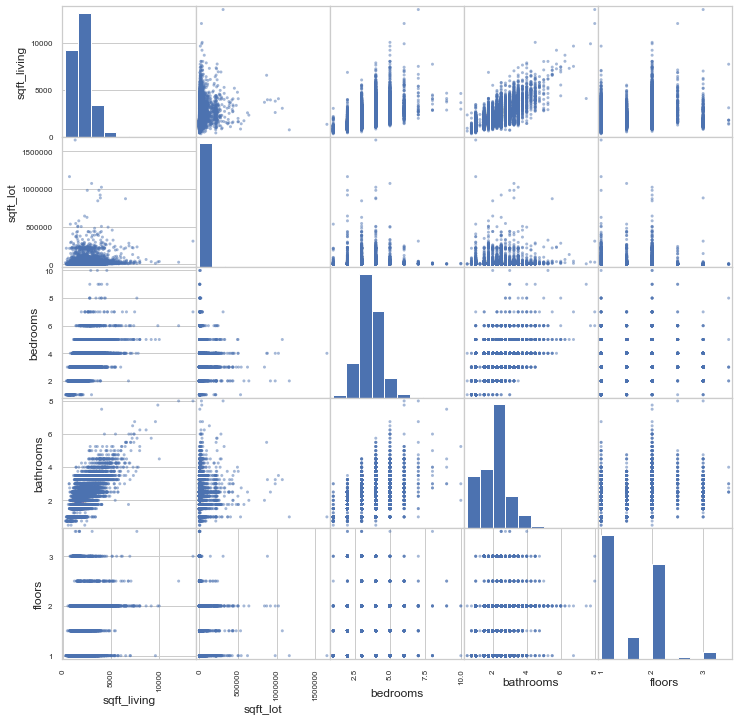

In [45]:
pd.plotting.scatter_matrix(training_data[["sqft_living", "sqft_lot","bedrooms","bathrooms","floors"]],figsize  = (12, 12));
plt.show()

In [50]:
training_data.shape

(17290, 76)

In [50]:
corra=training_data.corr()

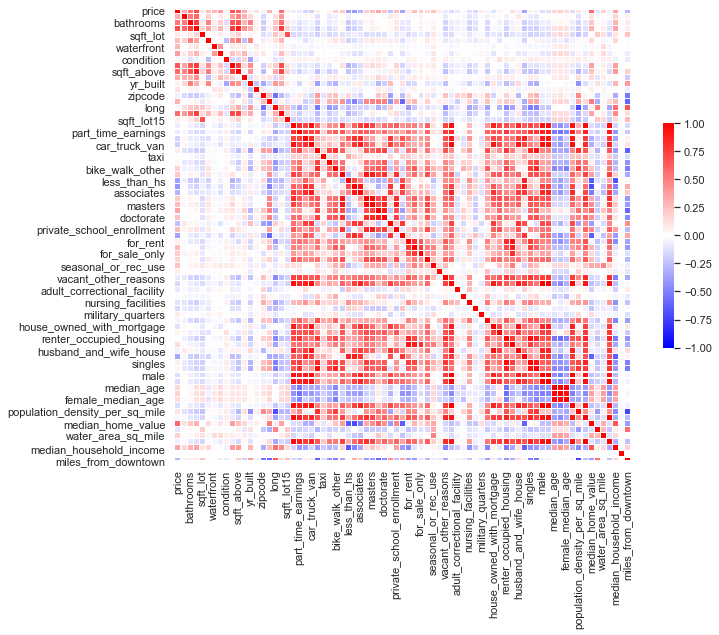

In [51]:

fig, ax = plt.subplots()

fig.set_size_inches(11.7, 8.27)


sns.heatmap(corra, cmap="bwr", vmax=1,vmin=-1, center=0, square = True,
             linewidths=.1, cbar_kws={"shrink": .5});

# Data Visualizations on Contineous Features:


In [109]:
training_data.shape

(17290, 75)

In [56]:
training_data["price"].max() 

7700000.0

In [57]:
training_data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,full_time_earnings,part_time_earnings,no_earnings,car_truck_van,public_transportation,taxi,motorcycle,bike_walk_other,work_home,less_than_hs,high_school_grad,associates,bachelors,masters,professional_school_degree,doctorate,public_school_enrollment,private_school_enrollment,no_school_enrollment,for_rent,rented_and_unoccupied,for_sale_only,sold_and_unoccupied,seasonal_or_rec_use,migrant_worker_housing,vacant_other_reasons,in_occupied_housing_units,adult_correctional_facility,juvenile_facilities,nursing_facilities,other_institutional,military_quarters,other_noninstitutional,house_owned_with_mortgage,house_owned_outright,renter_occupied_housing,vacant_households,husband_and_wife_house,single_guardian,singles,singles_with_roommate,male,female,median_age,male_median_age,female_median_age,population,population_density_per_sq_mile,total_housing_units,median_home_value,land_area,water_area_sq_mile,occupied_housing_units,median_household_income,month,miles_from_downtown
0,365000.0,4.0,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,10,23.357742
1,455000.0,4.0,1.75,2050,94525,1.0,0,0,4,7,1250,800,1959,0,98058,47.4492,-122.084,2270,47480,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,8,26.394534
2,273000.0,3.0,1.75,2050,9045,2.0,0,0,4,6,2050,0,1959,0,98058,47.4572,-122.180,1200,9045,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,8,20.904034
3,223000.0,2.0,1.00,910,9869,1.0,0,0,3,6,910,0,1957,0,98058,47.4572,-122.184,1480,9750,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,3,20.729671
4,335500.0,5.0,3.00,2240,19090,1.0,0,0,4,8,1700,540,1968,0,98058,47.4416,-122.149,2280,20000,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,7,23.692559


# Statistics to Determine the features

In [112]:
# checking the age of the house
training_data["house_years"] = abs(training_data["yr_renovated"]-training_data["yr_built"])

training_data["house_age_2015"] = 2015 - training_data["yr_built"] # age of the house by 25 with or without renovation. 


In [114]:
training_data.drop(columns= ["yr_built", "yr_renovated"], inplace = True)

In [115]:
training_data.shape

(17290, 75)

# Statistics on Categorical Features

In [62]:
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm


Ttest_indResult(statistic=37.72330429549608, pvalue=2.465038317654299e-299)

In [66]:
training.floors.value_counts()

1.0    8606
2.0    6538
1.5    1524
3.0     475
2.5     140
3.5       7
Name: floors, dtype: int64

In [67]:
formula = 'price~C(floors)'
lm = ols(formula, training_data).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table) 

                 sum_sq       df           F  PR(>F)
C(floors)  2.059096e+14      5.0  323.010561     0.0
Residual   2.203607e+15  17284.0         NaN     NaN


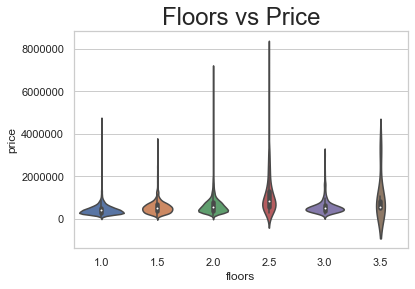

In [68]:
floors = training_data.groupby("floors").price.mean()
#floors.plot(kind=)
ax = sns.violinplot(x="floors", y="price", data=training_data)
plt.title("Floors vs Price", fontsize = 24)
plt.savefig('images/floors_vs_price.png', bbox_inches = "tight");

In [69]:
formula = 'price~C(grade)'
lm = ols(formula, training_data).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table) 

                sum_sq       df            F  PR(>F)
C(grade)  1.274417e+15     11.0  1763.511029     0.0
Residual  1.135100e+15  17278.0          NaN     NaN


In [70]:
training_data.groupby("grade").price.mean()

grade
1     1.420000e+05
3     1.685000e+05
4     2.106386e+05
5     2.438372e+05
6     3.026820e+05
7     4.025267e+05
8     5.430105e+05
9     7.741618e+05
10    1.072903e+06
11    1.507967e+06
12    2.314347e+06
13    4.002727e+06
Name: price, dtype: float64

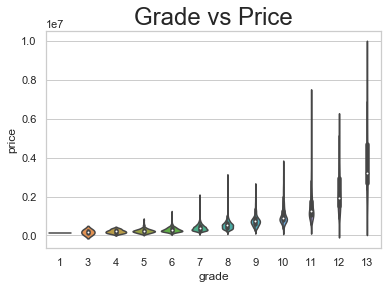

In [71]:
ax = sns.violinplot(x="grade", y="price", data=training_data)
plt.title("Grade vs Price", fontsize = 24)
plt.savefig('images/grade_vs_price.png', bbox_inches = "tight");

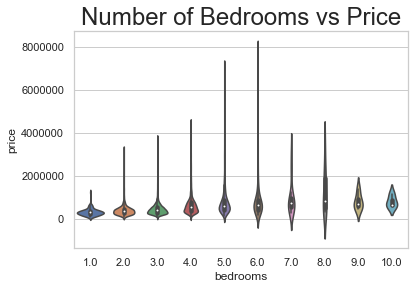

In [73]:
ax = sns.violinplot(x="bedrooms", y="price", data=training_data)
plt.title("Number of Bedrooms vs Price", fontsize = 24)
plt.savefig('images/bedroom_vs_price.png', bbox_inches = "tight");

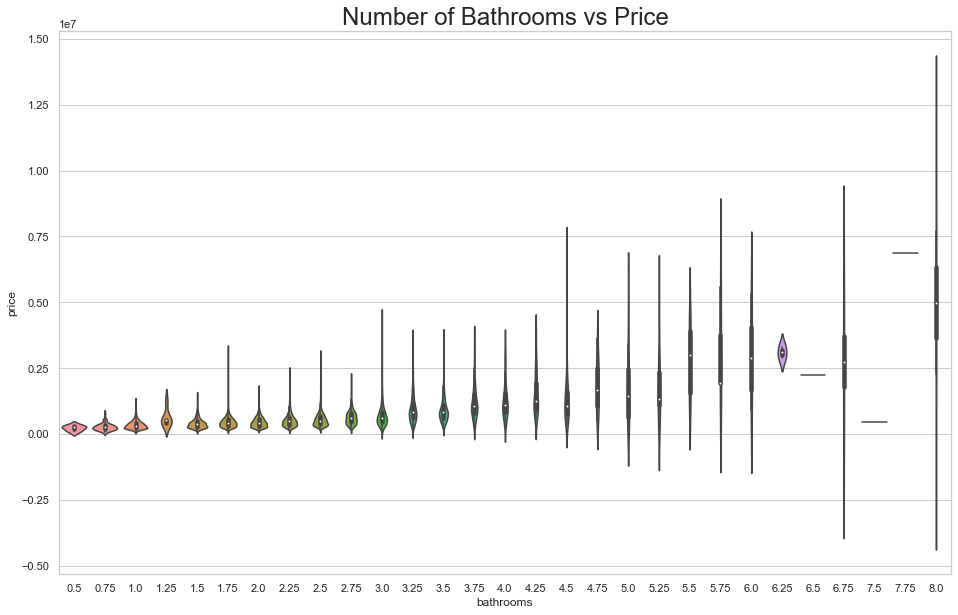

In [74]:
fix, ax = plt.subplots(figsize = (16,10))
ax = sns.violinplot(x="bathrooms", y="price", data=training_data)
plt.title("Number of Bathrooms vs Price", fontsize = 24)
plt.savefig('images/bathroom_vs_price.png', bbox_inches = "tight");

In [77]:
formula = 'price~C(no_earnings)'
lm = ols(formula, training_data).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table) 

                      sum_sq       df           F  PR(>F)
C(no_earnings)  9.673067e+14     69.0  167.386197     0.0
Residual        1.442210e+15  17220.0         NaN     NaN


In [78]:
training_data.groupby(["no_earnings", "zipcode"]).price.mean()

no_earnings  zipcode
953          98039      2.202790e+06
1154         98010      4.248736e+05
1253         98024      5.909915e+05
1348         98014      4.562057e+05
1605         98065      5.272174e+05
2410         98045      4.313185e+05
2418         98019      4.284222e+05
2500         98148      2.720823e+05
2836         98102      9.336715e+05
2870         98070      4.956727e+05
2980         98136      5.659156e+05
3350         98107      5.834824e+05
3398         98109      8.759879e+05
3472         98077      6.768898e+05
3825         98119      8.712724e+05
3961         98075      7.939692e+05
3964         98199      7.871469e+05
4305         98112      1.119458e+06
4636         98005      8.088476e+05
4675         98126      4.250761e+05
4711         98055      3.068521e+05
4720         98072      5.667307e+05
4773         98117      5.701880e+05
4913         98166      4.793758e+05
4998         98028      4.684170e+05
5137         98116      6.150221e+05
5292         9807

In [116]:
training_data.shape

(17290, 75)

In [140]:
training_data.shape

(17290, 75)

#### Conducting another base model test to see how the new features have affectted the model

In [141]:
X = training_data.drop(columns = "price")
y = training_data.price

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=42)

from sklearn.linear_model import LinearRegression
from sklearn import metrics

multi_lr_model = LinearRegression() # model

multi_lr_model.fit(X_train, y_train) # fit

y_pred = multi_lr_model.predict(X_test) # prediction

# model_score = multi_lr_model.score(X_test,y_test)
r_square = metrics.r2_score(y_test, y_pred)
# mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.median_absolute_error(y_test, y_pred)
# ev = metrics.explained_variance_score(y_test, y_pred)

# print(model_score)
# print(mse)
# print("Mae: ",  mae)
print("R Square               : ", r_square)
print("Root Mean Squared Error: ", mse**(1/2))

R Square               :  0.80500660640943
Root Mean Squared Error:  209328.90733385782


In [145]:
# waterfront_dummies = pd.get_dummies(training_data["waterfront"], prefix="wfront",  drop_first = True)
# view_dummies = pd.get_dummies(training_data["view"], prefix="view", drop_first = True)
# grade_dummies = pd.get_dummies(training_data["grade"], prefix="grade",  drop_first = True)
zipcode_dummies = pd.get_dummies(training_data["zipcode"], prefix="zipcode",  drop_first = True)
# bedroom_dummies = pd.get_dummies(training_data["bedrooms"], prefix="rooms",  drop_first = True)
# bathroom_dummies = pd.get_dummies(training_data["bathrooms"], prefix="bathrooms", drop_first = True)
# month_dummies = pd.get_dummies(training_data["month"], prefix="month", drop_first = True)



In [146]:
data_fin = pd.concat([training_data, zipcode_dummies], axis=1)
#holdout = pd.concat([holdout, waterfront_dummies_holdout, view_dummies_holdout, grade_dummies_holdout, zipcode_dummies_holdout , bedroom_dummies_holdout, bathroom_dummies_holdout, month_dummies_holdout], axis=1)

In [147]:
data_fin.shape

(17290, 144)

In [84]:
print(data_fin.shape)



(17290, 211)


# Linear Regression with SelectKBest

In [121]:
X = data_fin.drop(columns = "price")
y = data_fin.price

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=42)

from sklearn.linear_model import LinearRegression
from sklearn import metrics

multi_lr_model = LinearRegression() # model

multi_lr_model.fit(X_train, y_train) # fit

y_pred = multi_lr_model.predict(X_test) # prediction

# model_score = multi_lr_model.score(X_test,y_test)
r_square = metrics.r2_score(y_test, y_pred)
# mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.median_absolute_error(y_test, y_pred)
# ev = metrics.explained_variance_score(y_test, y_pred)

# print(model_score)
# print(mse)
# print("Mae: ",  mae)
print("R Square               : ", r_square)
print("Root Mean Squared Error: ", mse**(1/2))

R Square               :  0.8433739641097348
Root Mean Squared Error:  209328.90733385782


In [122]:
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

selector = SelectKBest(f_regression, k=205)

selector.fit(X_train, y_train)

SelectKBest(k=205, score_func=<function f_regression at 0x1a2b487d90>)

In [123]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [124]:
#instantiate a linear regression object
lm_kbest = LinearRegression()

#fit the linear regression to the data
lm_kbest = lm_kbest.fit(X_train[selected_columns], y_train)

y_train_kbest = lm_kbest.predict(X_train[selected_columns])


trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))


print('Training Root Mean Squared Error:' , trainK_rmse)

y_kbest = lm_kbest.predict(X_test[selected_columns])

testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

print('Testing Root Mean Squared Error:' , testK_rmse)

Training Root Mean Squared Error: 150630.10541822514
Testing Root Mean Squared Error: 138301.77796191128


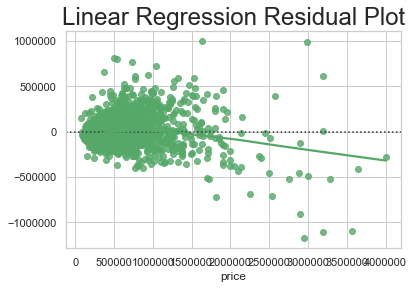

In [125]:
sns.residplot(y_test, y_kbest,lowess=True, color="g")
plt.title("Linear Regression Residual Plot", fontsize = 24)
plt.savefig('images/LR.png', bbox_inches = "tight");

there is heteroscadasticity.

# Generating Log Transformations and Interaction Features

In [90]:
data_log = pd.DataFrame([])
data_log['log_above'] = np.log(training_data['sqft_above'])
data_log['log_living'] = np.log(training_data['sqft_living'])
data_log['log_living15'] = np.log(training_data['sqft_living15'])
data_log['log_lot'] = np.log(training_data['sqft_lot'])
data_log['log_lot15'] = np.log(training_data['sqft_lot15'])
# data_log.hist(figsize  = [6, 6]);

In [91]:
training_data_dummies = pd.merge(training_data, data_log, how = "outer", left_index=True, right_index=True)

In [92]:
training_data_dummies.drop(columns = ['price','sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'sqft_above'], inplace = True)

In [93]:
training_data_dummies

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,full_time_earnings,part_time_earnings,no_earnings,car_truck_van,public_transportation,taxi,motorcycle,bike_walk_other,work_home,less_than_hs,high_school_grad,associates,bachelors,masters,professional_school_degree,doctorate,public_school_enrollment,private_school_enrollment,no_school_enrollment,for_rent,rented_and_unoccupied,for_sale_only,sold_and_unoccupied,seasonal_or_rec_use,migrant_worker_housing,vacant_other_reasons,in_occupied_housing_units,adult_correctional_facility,juvenile_facilities,nursing_facilities,other_institutional,military_quarters,other_noninstitutional,house_owned_with_mortgage,house_owned_outright,renter_occupied_housing,vacant_households,husband_and_wife_house,single_guardian,singles,singles_with_roommate,male,female,median_age,male_median_age,female_median_age,population,population_density_per_sq_mile,total_housing_units,median_home_value,land_area,water_area_sq_mile,occupied_housing_units,median_household_income,month,miles_from_downtown,house_years,house_age_2015,good_grade,log_above,log_living,log_living15,log_lot,log_lot15
0,4.0,2.25,2.0,0,0,4,8,0,1986,0,98058,47.4388,-122.162,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,10,23.357742,1986,29,0,7.635304,7.635304,7.779049,9.093020,8.948976
1,4.0,1.75,1.0,0,0,4,7,800,1959,0,98058,47.4492,-122.084,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,8,26.394534,1959,56,0,7.130899,7.625595,7.727535,11.456620,10.768064
2,3.0,1.75,2.0,0,0,4,6,0,1959,0,98058,47.4572,-122.180,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,8,20.904034,1959,56,0,7.625595,7.625595,7.090077,9.109967,9.109967
3,2.0,1.00,1.0,0,0,3,6,0,1957,0,98058,47.4572,-122.184,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,3,20.729671,1957,58,0,6.813445,6.813445,7.299797,9.197154,9.185023
4,5.0,3.00,1.0,0,0,4,8,540,1968,0,98058,47.4416,-122.149,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,7,23.692559,1968,47,0,7.438384,7.714231,7.731931,9.856920,9.903488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,4.0,3.75,1.0,0,0,3,9,1020,1963,2000,98039,47.6390,-122.236,807,385,953,890,34,0,0,40,57,12,290,68,922,388,146,51,555,355,32,13,0,32,9,19,0,28,2971,0,0,0,0,0,0,567,379,116,101,777,89,172,24,1468,1503,46,45,46,2971,2059,1163,1000001.0,1.44,4.30,1062,183833.0,3,8.604878,37,52,0,8.048788,8.330864,8.276395,9.765604,9.972080
17286,7.0,4.25,2.0,0,2,3,11,0,1992,0,98039,47.6183,-122.227,807,385,953,890,34,0,0,40,57,12,290,68,922,388,146,51,555,355,32,13,0,32,9,19,0,28,2971,0,0,0,0,0,0,567,379,116,101,777,89,172,24,1468,1503,46,45,46,2971,2059,1163,1000001.0,1.44,4.30,1062,183833.0,5,8.700660,1992,23,1,8.448914,8.448914,8.083329,10.048237,9.540507
17287,4.0,1.75,2.0,0,

In [94]:
X = training_data_dummies
y = prices

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=42)

from sklearn.linear_model import LinearRegression
from sklearn import metrics

log_model = LinearRegression() # model

log_model.fit(X_train, y_train) # fit

y_pred = log_model.predict(X_test) # prediction


r_square = metrics.r2_score(y_test, y_pred)

mae = metrics.median_absolute_error(y_test, y_pred)



print("R Square               : ", r_square)
print("Root Mean Squared Error: ", mse**(1/2))

R Square               :  -0.011295390469107325
Root Mean Squared Error:  154482.54436648844


In [95]:
#from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

selector = SelectKBest(f_regression, k=72)

selector.fit(X_train, y_train)

SelectKBest(k=72, score_func=<function f_regression at 0x1a247d2f28>)

In [96]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [97]:
#instantiate a linear regression object
lm_klogs = LinearRegression()

#fit the linear regression to the data
lm_klogs = lm_klogs.fit(X_train[selected_columns], y_train)

y_train_klogs = lm_klogs.predict(X_train[selected_columns])


trainKlogs_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_klogs))


print('Training Root Mean Squared Error:' , trainKlogs_rmse)

y_klogs = lm_klogs.predict(X_test[selected_columns])

testKlogs_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_klogs))

print('Testing Root Mean Squared Error:' , testKlogs_rmse)

Training Root Mean Squared Error: 374360.50990439794
Testing Root Mean Squared Error: 366810.4877926051


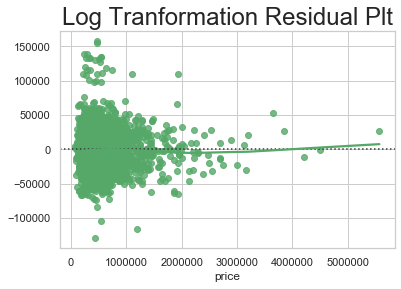

In [98]:
sns.residplot( y_test, y_klogs,lowess=True, color="g")
plt.title("Log Tranformation Residual Plt", fontsize = 24)
plt.savefig('images/Log.png', bbox_inches = "tight");

# Generating Polynomial and Interaction Features based on data_fin.
#### so far data_fin has a Training Root Mean Squared Error: 373014.63690137997 and training Training:  373014 vs. Testing:  367719. Which is worse than the naive model

In [99]:
data_fin.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,full_time_earnings,part_time_earnings,no_earnings,car_truck_van,public_transportation,taxi,motorcycle,bike_walk_other,work_home,less_than_hs,high_school_grad,associates,bachelors,masters,professional_school_degree,doctorate,public_school_enrollment,private_school_enrollment,no_school_enrollment,for_rent,rented_and_unoccupied,for_sale_only,sold_and_unoccupied,seasonal_or_rec_use,migrant_worker_housing,vacant_other_reasons,in_occupied_housing_units,adult_correctional_facility,juvenile_facilities,nursing_facilities,other_institutional,military_quarters,other_noninstitutional,house_owned_with_mortgage,house_owned_outright,renter_occupied_housing,vacant_households,husband_and_wife_house,single_guardian,singles,singles_with_roommate,male,female,median_age,male_median_age,female_median_age,population,population_density_per_sq_mile,total_housing_units,median_home_value,land_area,water_area_sq_mile,occupied_housing_units,median_household_income,month,miles_from_downtown,house_years,house_age_2015,good_grade,wfront_1,view_1,view_2,view_3,view_4,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,rooms_2.0,rooms_3.0,rooms_4.0,rooms_5.0,rooms_6.0,rooms_7.0,rooms_8.0,rooms_9.0,rooms_10.0,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0,bathrooms_6.25,bathrooms_6.5,bathrooms_6.75,bathrooms_7.5,bathrooms_7.75,bathrooms_8.0,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,365000.0,4.0,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,10,23.357742,1986,29,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,455000.0,4.0,1.75,2050,94525,1.0,0,0,4,7,1250,800,1959,0,98058,47.4492,-122.084,2270,47480,15510,9689,9208,19448,1126,0,65,286,1067,2447,13469,3249,7929,2153,274,226,7014,847,1248,272,29,162,35,58,0,169,41809,0,0,22,5,0,102,8929,2270,4196,725,8685,2490,3215,1005,20786,21152,38,37,38,41938,2215,16120,302200.0,18.93,0.83,15395,77780.0,8,26.394534,1959,56,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [100]:
poly_2_data=data_fin.drop(columns = "price")
poly_2 = PolynomialFeatures(degree=2, include_bias=False)
poly2_data = poly_2.fit_transform(data_fin.drop(columns = "price"))
poly2_columns = poly_2.get_feature_names(poly_2_data.columns)
df_poly2 = pd.DataFrame(poly2_data, columns=poly2_columns)
df_poly2.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,full_time_earnings,part_time_earnings,no_earnings,car_truck_van,public_transportation,taxi,motorcycle,bike_walk_other,work_home,less_than_hs,high_school_grad,associates,bachelors,masters,professional_school_degree,doctorate,public_school_enrollment,private_school_enrollment,no_school_enrollment,for_rent,rented_and_unoccupied,for_sale_only,sold_and_unoccupied,seasonal_or_rec_use,migrant_worker_housing,vacant_other_reasons,in_occupied_housing_units,adult_correctional_facility,juvenile_facilities,nursing_facilities,other_institutional,military_quarters,other_noninstitutional,house_owned_with_mortgage,house_owned_outright,renter_occupied_housing,vacant_households,husband_and_wife_house,single_guardian,singles,singles_with_roommate,male,female,median_age,male_median_age,female_median_age,population,population_density_per_sq_mile,total_housing_units,median_home_value,land_area,water_area_sq_mile,occupied_housing_units,median_household_income,month,miles_from_downtown,house_years,house_age_2015,good_grade,wfront_1,view_1,view_2,view_3,view_4,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,rooms_2.0,rooms_3.0,rooms_4.0,rooms_5.0,rooms_6.0,rooms_7.0,rooms_8.0,rooms_9.0,rooms_10.0,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0,bathrooms_6.25,bathrooms_6.5,bathrooms_6.75,bathrooms_7.5,bathrooms_7.75,bathrooms_8.0,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,bedrooms^2,bedrooms bathrooms,bedrooms sqft_living,bedrooms sqft_lot,bedrooms floors,bedrooms waterfront,bedrooms view,bedrooms condition,bedrooms grade,bedrooms sqft_above,bedrooms sqft_basement,bedrooms yr_built,bedrooms yr_renovated,bedrooms zipcode,bedrooms lat,bedrooms long,bedrooms sqft_living15,bedrooms sqft_lot15,bedrooms full_time_earnings,bedrooms part_time_earnings,bedrooms no_earnings,bedrooms car_truck_van,bedrooms public_transportation,bedrooms taxi,bedrooms motorcycle,bedrooms bike_walk_other,bedrooms work_home,bedrooms less_than_hs,bedrooms high_school_grad,bedrooms associates,bedrooms bachelors,bedrooms masters,bedrooms professional_school_degree,bedrooms doctorate,bedrooms public_school_enrollment,bedrooms private_school_enrollment,bedrooms no_school_enrollment,bedrooms for_rent,bedrooms rented_and_unoccupied,bedrooms for_sale_only,...,bathrooms_5.0 bathrooms_5.75,bathrooms_5.0 bathrooms_6.0,bathrooms_5.0 bathrooms_6.25,bathrooms_5.0 bathrooms_6.5,bathrooms_5.0 bathrooms_6.75,bathrooms_5.0 bathrooms_7.5,bathrooms_5.0 bathrooms_7.75,bathrooms_5.0 bathrooms_8.0,bathrooms_5.0 month_2,bathrooms_5.0 mont

In [101]:
X_train, X_test, y_train, y_test = train_test_split(df_poly2, prices, random_state=30,test_size=0.2)

In [102]:
# from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression

selector = SelectKBest(f_regression, k=1000)

selector.fit(X_train, y_train)

SelectKBest(k=1000, score_func=<function f_regression at 0x1a247d2f28>)

In [103]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]

In [104]:
list(selected_columns)

['bedrooms',
 'sqft_lot',
 'military_quarters',
 'grade_4',
 'zipcode_98029',
 'zipcode_98119',
 'rooms_2.0',
 'rooms_5.0',
 'month_2',
 'month_4',
 'month_5',
 'month_6',
 'month_9',
 'bedrooms sqft_lot',
 'bedrooms condition',
 'bedrooms yr_built',
 'bedrooms zipcode',
 'bedrooms lat',
 'bedrooms long',
 'bedrooms sqft_lot15',
 'bedrooms military_quarters',
 'bedrooms median_age',
 'bedrooms male_median_age',
 'bedrooms female_median_age',
 'bedrooms house_years',
 'bedrooms grade_4',
 'bedrooms grade_8',
 'bedrooms zipcode_98022',
 'bedrooms zipcode_98029',
 'bedrooms zipcode_98119',
 'bedrooms rooms_2.0',
 'bedrooms rooms_5.0',
 'bedrooms bathrooms_4.5',
 'bedrooms month_2',
 'bedrooms month_4',
 'bedrooms month_6',
 'bathrooms sqft_lot',
 'bathrooms less_than_hs',
 'bathrooms military_quarters',
 'bathrooms grade_4',
 'bathrooms zipcode_98022',
 'bathrooms zipcode_98029',
 'bathrooms zipcode_98039',
 'bathrooms zipcode_98119',
 'bathrooms rooms_2.0',
 'bathrooms rooms_6.0',
 'bath

In [105]:
#instantiate a linear regression object
lm_poly2 = LinearRegression()

#fit the linear regression to the data
lm_poly2 = lm_kbest.fit(X_train[selected_columns], y_train)

y_train_poly2 = lm_kbest.predict(X_train[selected_columns])


poly2_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_poly2))


print('Training Root Mean Squared Error:' , poly2_rmse)

y_poly2 = lm_poly2.predict(X_test[selected_columns])

poly2_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_poly2))

print('Testing Root Mean Squared Error:' , poly2_rmse)


Training Root Mean Squared Error: 352440.99357568735
Testing Root Mean Squared Error: 385548.2178182484


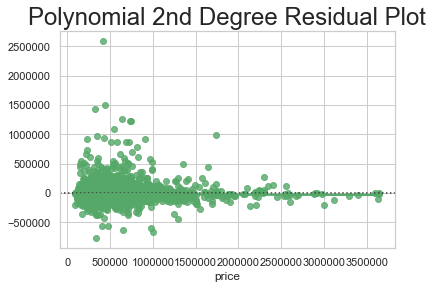

In [106]:
sns.residplot( y_test, y_poly2,lowess=True, color="g")
plt.title("Polynomial 2nd Degree Residual Plot", fontsize = 24)
plt.savefig('images/poly.png', bbox_inches = "tight");

### Trying Predictions on the Holdout. Linear Regression with SelectKBest produced the least RMSE value

In [150]:
prices = pd.DataFrame(data_fin["price"])
prices.to_csv("datasets/prices.csv")
prices = pd.read_csv("datasets/prices.csv", index_col = 0)
data_fin.drop(columns = "price", inplace = True)


In [151]:
data_fin.shape

(17290, 143)

In [152]:
X = data_fin
y = prices.price


multi_lr_model = LinearRegression() # model

multi_lr_model.fit(X, y) # fit



# y_pred = multi_lr_model.predict(holdout) # prediction



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [153]:

selector = SelectKBest(f_regression, k=100)

selector.fit(X, y);

In [154]:
selected_columns = X.columns[selector.get_support()]
removed_columns = X.columns[~selector.get_support()]


In [155]:
len(selected_columns)

100

In [156]:
data_fin[selected_columns].to_csv("final_data.csv")

In [158]:
# multi_lr_model = LinearRegression()

# #fit the linear regression to the data
# lm_kbest = lm_kbest.fit(X_train[selected_columns], y_train)

# y_train_kbest = lm_kbest.predict(X_train[selected_columns])


# trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))


# print('Training Root Mean Squared Error:' , trainK_rmse)

# y_kbest = lm_kbest.predict(X_test[selected_columns])
# testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

# print('Testing Root Mean Squared Error:' , testK_rmse)

In [ ]:
len(selected_columns)

In [159]:
#instantiate a linear regression object
lm_final = LinearRegression()

#fit the linear regression to the data
lm_final.fit(data_fin[selected_columns], prices)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [160]:
lm_final.coef_

array([[-3.01477455e+04,  2.74340887e+04,  1.17857586e+02,
         2.10171622e-01, -4.89629280e+04,  6.66507061e+05,
         5.51296674e+04,  5.59155216e+04,  9.79699802e+01,
         1.98875998e+01, -1.15740377e+03,  3.36106236e+04,
         7.19186526e+00, -5.58253980e-02, -1.95711963e+02,
        -1.40759465e+02, -1.13190975e+02,  2.11969460e+02,
         6.03104811e+01,  2.00372340e+02, -1.69699124e+02,
         1.17656790e+02, -8.83254182e+00,  1.00260651e+02,
        -1.00899549e+02,  5.22351816e+00,  4.95358452e+01,
         2.92160814e+02, -5.60949475e+01, -1.46139268e+01,
         3.87965078e+01,  1.04317257e+03, -9.69754774e+00,
         3.14965030e+02,  3.48098748e+03,  5.80116103e+02,
        -6.09728602e+03,  2.58497489e+02,  1.50294863e+01,
        -1.26594614e+02,  1.30163814e+03,  4.96464196e+02,
         2.51123720e+02, -8.22221707e+01, -4.29244899e+02,
         2.09818862e+02, -5.04930416e+02, -1.69675716e+01,
         2.37979737e+02, -8.05172703e+01,  1.09110426e+0

In [161]:
import pickle


pickle_out = open("lm_final.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()